In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
# import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.layers import Dropout, GRU, Dense, Conv1D, Conv2D, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt

# Set up plot style
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

2024-08-26 10:16:53.293442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Helper Functions for Technical Indicators
def SMA(df, window_size):
    """
    Calculate the Simple Moving Average (SMA) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the SMA.
    
    Returns:
    Series: The SMA values.
    """
    return df['Close'].rolling(window=window_size).mean()

def EMA(df, window_size):
    """
    Calculate the Exponential Moving Average (EMA) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the EMA.
    
    Returns:
    Series: The EMA values.
    """
    return df['Close'].ewm(span=window_size).mean()

def MACD(df, short_window, long_window):
    """
    Calculate the Moving Average Convergence Divergence (MACD) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    short_window (int): The window size for the short EMA.
    long_window (int): The window size for the long EMA.
    
    Returns:
    Series: The MACD values.
    """
    short_EMA = EMA(df, short_window)
    long_EMA = EMA(df, long_window)
    return short_EMA - long_EMA

def RSI(df, window_size):
    """
    Calculate the Relative Strength Index (RSI) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the RSI.
    
    Returns:
    Series: The RSI values.
    """
    delta = df['Close'].diff()
    delta = delta[1:] 
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window_size - 1, min_periods=window_size).mean()
    ema_down = down.ewm(com=window_size - 1, min_periods=window_size).mean()
    return ema_up / ema_down

def Bollinger_Bands(df, window_size):
    """
    Calculate the Bollinger Bands for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the Bollinger Bands.
    
    Returns:
    Tuple[Series, Series]: The upper and lower Bollinger Bands.
    """
    middle_band = SMA(df, window_size)
    std_dev = df['Close'].rolling(window=window_size).std()
    upper_band = middle_band + (std_dev * 2)
    lower_band = middle_band - (std_dev * 2)
    return upper_band, lower_band

def create_sequences(df, seq_length):
    """
    Create sequences of df for time series forecasting.
    
    Parameters:
    df (dfFrame): The input df.
    seq_length (int): The length of each sequence.
    
    Returns:
    Tuple[np.ndarray, np.ndarray]: Arrays of input sequences and corresponding targets.
    """
    xs = []
    ys = []
    
    for i in range(len(df) - seq_length - 1):
        x = df.iloc[i:(i + seq_length)].values
        y = df.iloc[(i + seq_length)]['Close']
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

def gain(x):
    """
    Calculate the gain from an array of differences.
    
    Parameters:
    x (np.ndarray): The array of differences.
    
    Returns:
    float: The total gain.
    """
    return ((x > 0) * x).sum()

def loss(x):
    """
    Calculate the loss from an array of differences.
    
    Parameters:
    x (np.ndarray): The array of differences.
    
    Returns:
    float: The total loss.
    """
    return ((x < 0) * x).sum()

def MFI(df, n=14):
    """
    Calculate the Money Flow Index (MFI) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'High', 'Low', 'Close', and 'Volume' columns.
    n (int): The window size for calculating the MFI.
    
    Returns:
    np.ndarray: The MFI values.
    """
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()

def ATR(df, n=14):
    """
    Calculate the Average True Range (ATR) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'High', 'Low', and 'Close' columns.
    n (int): The window size for calculating the ATR.
    
    Returns:
    np.ndarray: The ATR values.
    """
    high = df['High']
    low = df['Low']
    close = df['Close']
    tr = np.amax(np.vstack(((high - low).to_numpy(), (abs(high - close)).to_numpy(), (abs(low - close)).to_numpy())).T, axis=1)
    return pd.Series(tr).rolling(n).mean().to_numpy()

def ForceIndex(df, ndays): 
    """
    Calculate the Force Index for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'Close' and 'Volume' columns.
    ndays (int): The window size for calculating the Force Index.
    
    Returns:
    dfFrame: The df with the Force Index column added.
    """
    FI = pd.Series(df['Close'].diff(ndays) * df['Volume'], name='ForceIndex')
    df = df.join(FI)
    return df

def EMV(df, ndays): 
    """
    Calculate the Ease of Movement (EMV) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'High', 'Low', and 'Volume' columns.
    ndays (int): The window size for calculating the EMV.
    
    Returns:
    dfFrame: The df with the EMV column added.
    """
    dm = ((df['High'] + df['Low']) / 2) - ((df['High'].shift(1) + df['Low'].shift(1)) / 2)
    br = (df['Volume'] / 100000000) / (df['High'] - df['Low'])
    EMV = dm / br 
    EMV_MA = pd.Series(EMV.rolling(ndays).mean(), name='EMV')
    df = df.join(EMV_MA)
    return df

def add_lags(df):
    """
    Add lagged features to the DataFrame for various time periods.

    Parameters:
    df (DataFrame): The input DataFrame with at least 'High', 'Low', 'Open', and 'Close' columns.

    Returns:
    DataFrame: The DataFrame with added lagged features for day, week, month, quarter, and year.
    """
    df['lag day high'] = df['High'].shift(1)
    df['lag day low'] = df['Low'].shift(1)
    df['lag day open'] = df['Open'].shift(1)
    df['lag day close'] = df['Close'].shift(1)
    df['lag week close'] = df['Close'].shift(5)
    df['lag month close'] = df['Close'].shift(20)
    df['lag quarter close'] = df['Close'].shift(60)
    df['lag year close'] = df['Close'].shift(252)
    return df

def create_time_features(df):
    """
    Create time-based features from the DataFrame index, which should be a datetime index.

    Parameters:
    df (DataFrame): The input DataFrame with a datetime index.

    Returns:
    DataFrame: The DataFrame with added time-based features such as day of the week, month, quarter, etc.
    """
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

def make_3D(data, seq_length, features, target):
    """
    Transform the data into 3D format suitable for LSTM/GRU models by creating sequences.

    Parameters:
    data (DataFrame): The input DataFrame.
    seq_length (int): The length of the input sequences.
    features (list): List of feature column names to be included in each sequence.
    target (str): The target column name.

    Returns:
    Tuple[np.ndarray, np.ndarray]: 3D numpy arrays for input sequences (X) and corresponding targets (y).
    """
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)][features].values
        y = data.iloc[i + seq_length][target]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Data Preparation
def load_and_prepare_data(file_path):
    """
    Load the data from a CSV file, compute technical indicators and time-based features, 
    and prepare it for modeling.

    Parameters:
    file_path (str): The file path to the CSV data.

    Returns:
    DataFrame: The prepared DataFrame with technical indicators and time-based features.
    """
    df = pd.read_csv(file_path)
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    df = add_lags(df)
    df['SMA'] = SMA(df, 14)
    df['EMA'] = EMA(df, 14)
    df['MACD'] = MACD(df, 12, 26)
    df['RSI'] = RSI(df, 14)
    df['Upper_band'], df['Lower_band'] = Bollinger_Bands(df, 14)
    df['MFI'] = MFI(df, 14)
    df['ATR'] = ATR(df, 14)
    df['ForceIndex'] = ForceIndex(df, 14)['ForceIndex']
    df['EMV'] = EMV(df, 14)['EMV']
    df = create_time_features(df)
    df = df.dropna()

    return df

def train_and_evaluate(model, df, seq_length=3, batch_size=64, epochs=100, features = [], target='', n_splits=5, test_size=120):
    """
    Train and evaluate a given model using time series cross-validation.
    
    Parameters:
    - model: A compiled Keras model instance to be trained and evaluated.
    - df: DataFrame containing the prepared data.
    - seq_length: The length of the input sequences for the model.
    - batch_size: The number of samples per gradient update.
    - epochs: Number of epochs to train the model.
    - features: A list of features used in training the model.
    - target: A string used to denote the target for the model.
    - n_splits: Number of cross validation sets.
    - test_size: Number of samples in cross validation sets.
    
    Returns:
    - preds: List of DataFrames containing predictions for each fold.
    - scores: List of RMSE scores for each fold.
    """
    
    tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=0)
    preds = []
    scores = []
    
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx].copy()
        test = df.iloc[val_idx].copy()

        # Ensure the columns are float before scaling
        train.loc[:, features] = train[features].astype(float)
        test.loc[:, features] = test[features].astype(float)


        # Scale features
        scaler_features = MinMaxScaler()
        train.loc[:, features] = scaler_features.fit_transform(train[features])
        test.loc[:, features] = scaler_features.transform(test[features])

        # Ensure target is float before scaling
        train.loc[:, [target]] = train[[target]].astype(float) 
        test.loc[:, [target]] = test[[target]].astype(float)

        # Scale target
        scaler_target = MinMaxScaler()
        train.loc[:, target] = scaler_target.fit_transform(train[[target]])
        test.loc[:, target] = scaler_target.transform(test[[target]])
        
        X_train, y_train = make_3D(train, seq_length, features=features, target=target)
        X_test, y_test = make_3D(test, seq_length, features=features, target=target)

        # Train the model
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
        
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Inverse transform predictions and true values to original scale
        y_pred_original = scaler_target.inverse_transform(y_pred)
        y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))
        
        # Calculate RMSE
        score = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
        scores.append(score)
        preds.append(pd.DataFrame(y_pred_original, index=test.index[seq_length:], columns=['prediction']))
        
        print(f'RMSE across folds {np.mean(scores):0.4f}')
        print(f'Fold RMSE: {scores}')
    
    return preds, scores


# Visualization Functions
def plot_cross_validation_splits(df, tss):
    """
    Plot the training and testing data for each cross-validation fold.

    Parameters:
    df (DataFrame): The input DataFrame with at least the 'Close' column.
    tss (TimeSeriesSplit): The time series split object from scikit-learn for cross-validation.

    Returns:
    None: Displays the plot.
    """
    fig, axs = plt.subplots(tss.get_n_splits(), 1, figsize=(15, 15), sharex=True)
    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train['Close'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
        test['Close'].plot(ax=axs[fold], label='Test Set')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        fold += 1
    plt.show()

def plot_predictions(df, preds):
    """
    Plot the true data and model predictions for the full dataset and the last 120 trading days.

    Parameters:
    df (DataFrame): The input DataFrame with at least the 'Close' column.
    preds (list of DataFrames): List of DataFrames containing predictions for each cross-validation fold.

    Returns:
    None: Displays the plots.
    """
    predictions = pd.concat(preds)
    df = df.merge(predictions, how='left', left_index=True, right_index=True)

    # Plotting full data with predictions
    ax = df[['Close']].plot(figsize=(15, 5))
    df['prediction'].plot(ax=ax, style='.')
    plt.legend(['True Data', 'Predictions'])
    ax.set_title('True Data and Prediction')
    plt.show()

    # Plotting last 120 trading days with predictions
    ax = df.loc[df.tail(240).index]['Close'].plot(figsize=(15, 5), title='120 Trading Days Of Data')
    df.loc[df.tail(240).index]['prediction'].plot(style='.')
    plt.legend(['True Data', 'Prediction'])
    plt.show()



In [3]:
# Prepare data
df = load_and_prepare_data('GOOGL_large.csv')

In [4]:
cnn_features = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag day high', 'lag day low', 'lag day open',
            'lag quarter close', 'SMA', 'EMA', 'MACD', 'RSI',
            'Upper_band', 'Lower_band', 'MFI', 'ATR', 'ForceIndex', 'EMV']
cnn_target = 'Close'
cnn_timestep = 10
cnn_input_shape = (cnn_timestep, len(cnn_features))

# Define the model architecture for CNN
cnn_model = Sequential()
cnn_model.add(Input(shape=cnn_input_shape))
cnn_model.add(Conv1D(64, kernel_size=10, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])

# Train and evaluate the CNN model
print("Training CNN Model...")
preds_cnn, scores_cnn = train_and_evaluate(model=cnn_model, df=df, seq_length=cnn_timestep,
                                           batch_size=64, epochs=100, features=cnn_features,
                                           target=cnn_target, n_splits=10, test_size=180)



Training CNN Model...


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.25549451 0.25824176 0.26098901]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.   0.25 0.5 ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
RMSE across folds 0.9070
Fold RMSE: [0.9070142688635624]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.95879121 0.96703297 0.96978022]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 1.   0.   0.25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
RMSE across folds 0.7418
Fold RMSE: [0.9070142688635624, 0.5764958730796289]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.67857143 0.68131868 0.68406593]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
RMSE across folds 0.8417
Fold RMSE: [0.9070142688635624, 0.5764958730796289, 1.0414842896191403]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.39010989 0.39285714 0.40384615]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.75 1.   0.25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
RMSE across folds 0.9245
Fold RMSE: [0.9070142688635624, 0.5764958730796289, 1.0414842896191403, 1.17308446485094]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.11263736 0.11538462 0.11813187]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
RMSE across folds 0.9986
Fold RMSE: [0.9070142688635624, 0.5764958730796289, 1.0414842896191403, 1.17308446485094, 1.2949136645490753]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.82417582 0.82692308 0.82967033]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE across folds 1.1732
Fold RMSE: [0.9070142688635624, 0.5764958730796289, 1.0414842896191403, 1.17308446485094, 1.2949136645490753, 2.045980497452633]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.54120879 0.54945055 0.5521978 ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 1.   0.   0.25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
RMSE across folds 1.3044
Fold RMSE: [0.9070142688635624, 0.5764958730796289, 1.0414842896191403, 1.17308446485094, 1.2949136645490753, 2.045980497452633, 2.092064465005357]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.25824176 0.26098901 0.26373626]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE across folds 1.4793
Fold RMSE: [0.9070142688635624, 0.5764958730796289, 1.0414842896191403, 1.17308446485094, 1.2949136645490753, 2.045980497452633, 2.092064465005357, 2.703143720555952]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.96703297 0.96978022 0.97252747]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.   0.25 0.5 ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
RMSE across folds 1.7547
Fold RMSE: [0.9070142688635624, 0.5764958730796289, 1.0414842896191403, 1.17308446485094, 1.2949136645490753, 2.045980497452633, 2.092064465005357, 2.703143720555952, 3.9580411399969346]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.68406593 0.68681319 0.69505495]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.75 1.   0.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
RMSE across folds 1.8298
Fold RMSE: [0.9070142688635624, 0.5764958730796289, 1.0414842896191403, 1.17308446485094, 1.2949136645490753, 2.045980497452633, 2.092064465005357, 2.703143720555952, 3.9580411399969346, 2.5052860224962843]


RMSE across folds 1.8298
Fold RMSE: [0.9070142688635624, 0.5764958730796289, 1.0414842896191403, 1.17308446485094, 1.2949136645490753, 2.045980497452633, 2.092064465005357, 2.703143720555952, 3.9580411399969346, 2.5052860224962843]


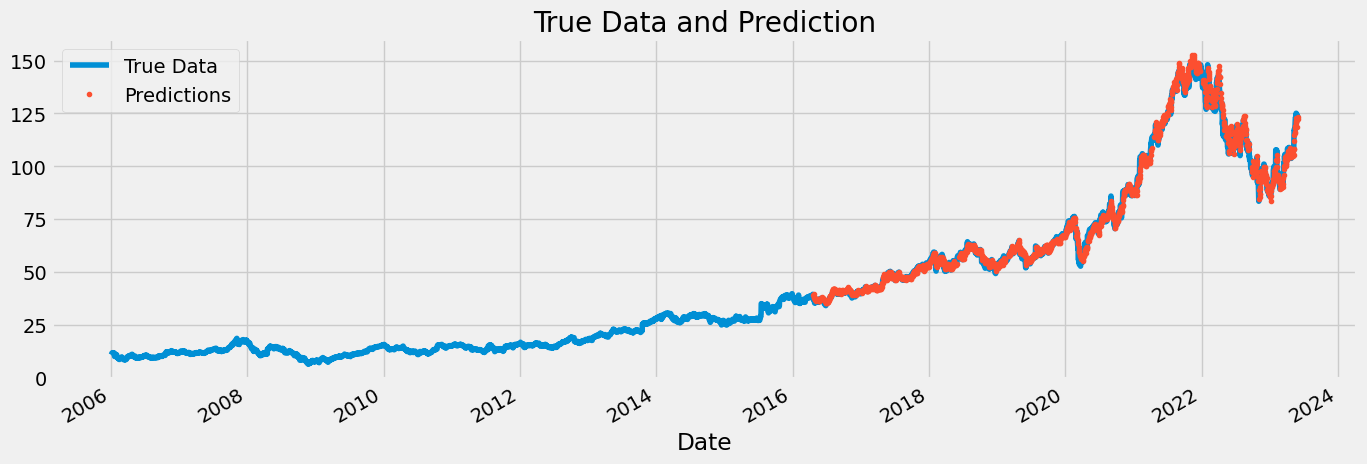

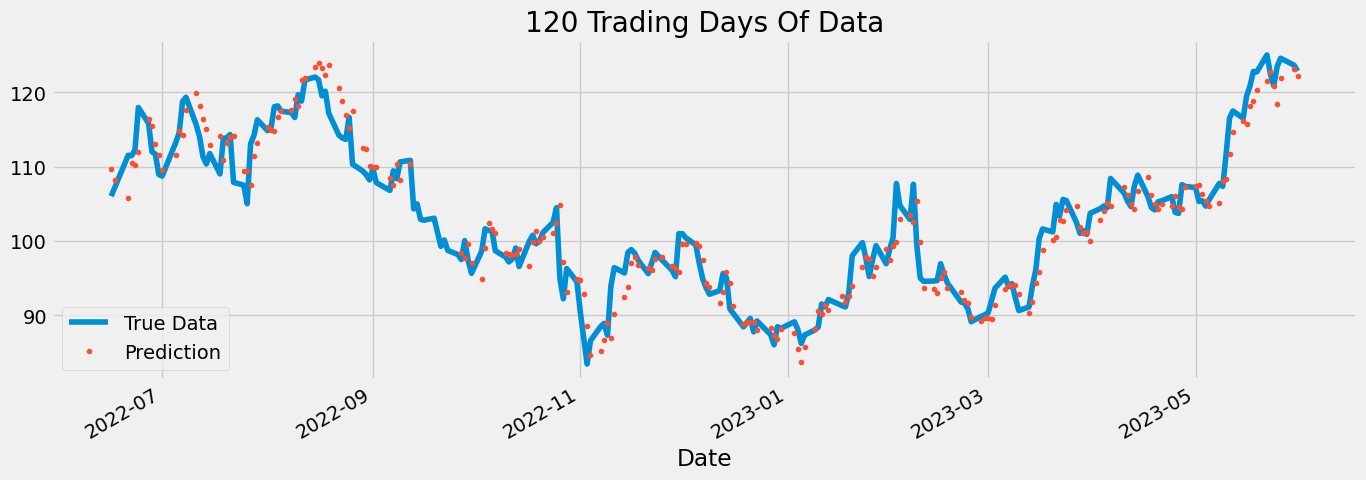

In [5]:
# Visualize results
print(f'RMSE across folds {np.mean(scores_cnn):0.4f}')
print(f'Fold RMSE: {scores_cnn}')
plot_predictions(df, preds_cnn)

In [6]:
# Train and evaluate the LSTM model
lstm_features = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag day high', 'lag day low', 'lag day open',
            'lag quarter close', 'SMA', 'EMA', 'MACD', 'RSI',
            'Upper_band', 'Lower_band', 'MFI', 'ATR', 'ForceIndex', 'EMV']
lstm_target = 'Close'
lstm_timestep = 10
lstm_input_shape = (lstm_timestep, len(lstm_features))

lstm_model = Sequential()
lstm_model.add(Input(shape=lstm_input_shape))
lstm_model.add(LSTM(units=64, return_sequences=False))
lstm_model.add(Dense(units=32))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])

print("Training LSTM Model...")
preds_lstm, scores_lstm = train_and_evaluate(model=lstm_model, df=df, seq_length=lstm_timestep,
                                             batch_size=64, epochs=100, features=lstm_features,
                                             target=lstm_target, n_splits=5, test_size=180) 



Training LSTM Model...


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.82417582 0.82692308 0.82967033]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
RMSE across folds 1.8126
Fold RMSE: [1.8125945389584137]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.54120879 0.54945055 0.5521978 ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 1.   0.   0.25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE across folds 2.5365
Fold RMSE: [1.8125945389584137, 3.2603347041277595]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.25824176 0.26098901 0.26373626]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE across folds 2.4008
Fold RMSE: [1.8125945389584137, 3.2603347041277595, 2.129442680274805]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.96703297 0.96978022 0.97252747]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.   0.25 0.5 ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE across folds 3.1497
Fold RMSE: [1.8125945389584137, 3.2603347041277595, 2.129442680274805, 5.396273010248136]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.68406593 0.68681319 0.69505495]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.75 1.   0.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RMSE across folds 3.0450
Fold RMSE: [1.8125945389584137, 3.2603347041277595, 2.129442680274805, 5.396273010248136, 2.626421913823141]


RMSE across folds 3.0450
Fold RMSE: [1.8125945389584137, 3.2603347041277595, 2.129442680274805, 5.396273010248136, 2.626421913823141]


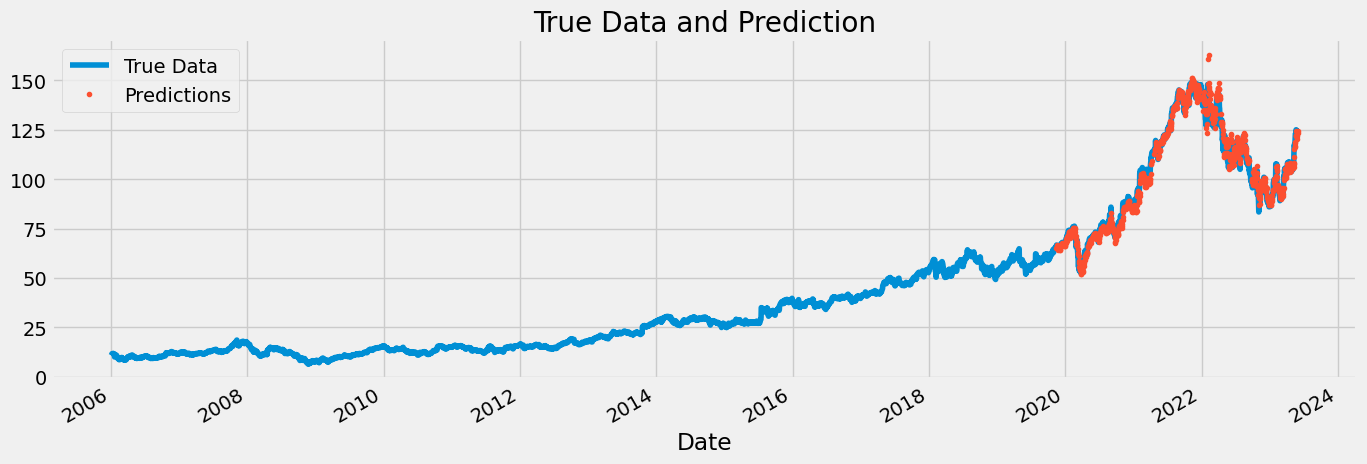

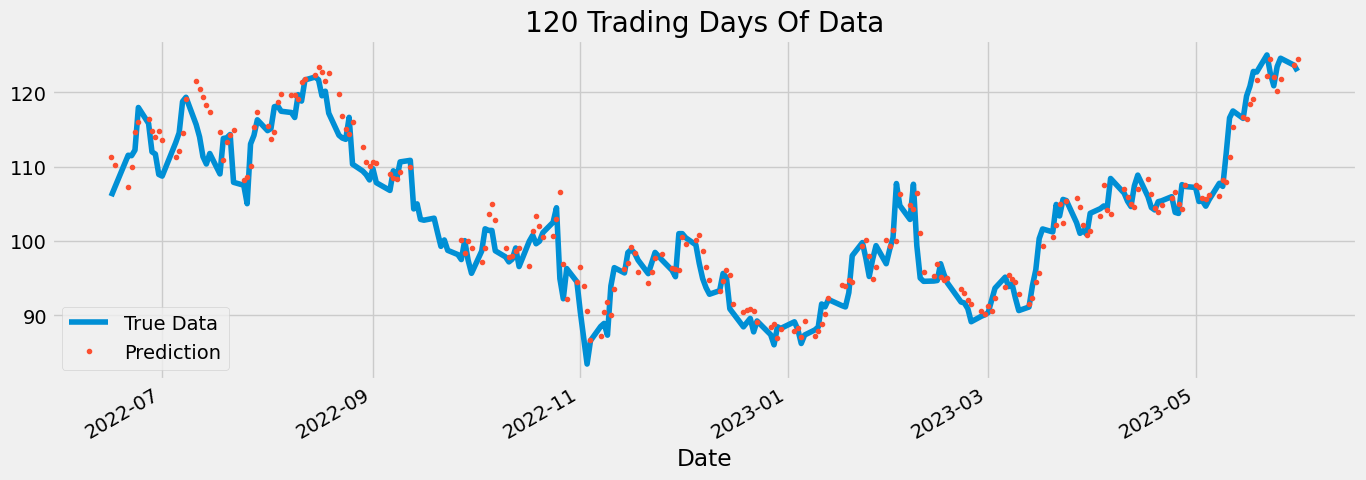

In [7]:
# Visualize results
print(f'RMSE across folds {np.mean(scores_lstm):0.4f}')
print(f'Fold RMSE: {scores_lstm}')
plot_predictions(df, preds_lstm)

In [8]:
# Define features and target for GRU
gru_features = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag day high', 'lag day low', 'lag day open',
            'lag quarter close', 'SMA', 'EMA', 'MACD', 'RSI',
            'Upper_band', 'Lower_band', 'MFI', 'ATR', 'ForceIndex', 'EMV']
gru_target = 'Close'
gru_timestep = 10
gru_input_shape = (gru_timestep, len(gru_features))

gru_model = Sequential()
gru_model.add(Input(shape=gru_input_shape))
gru_model.add(GRU(64, return_sequences=False))
gru_model.add(Dense(32))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])

# Train and evaluate the GRU model
print("Training GRU Model...")
preds_gru, scores_gru = train_and_evaluate(gru_model, df, seq_length=gru_timestep,
                                           batch_size=64, epochs=100, features=gru_features,
                                           target=gru_target, n_splits=5, test_size=180)



Training GRU Model...


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.82417582 0.82692308 0.82967033]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
RMSE across folds 1.6453
Fold RMSE: [1.6453200131883747]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.54120879 0.54945055 0.5521978 ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 1.   0.   0.25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE across folds 1.8154
Fold RMSE: [1.6453200131883747, 1.9855528336990793]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.25824176 0.26098901 0.26373626]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE across folds 1.9787
Fold RMSE: [1.6453200131883747, 1.9855528336990793, 2.3052789849740267]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.96703297 0.96978022 0.97252747]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.   0.25 0.5 ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE across folds 2.8000
Fold RMSE: [1.6453200131883747, 1.9855528336990793, 2.3052789849740267, 5.263719835740067]


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00274725 0.00549451 0.00824176 ... 0.68406593 0.68681319 0.69505495]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.5  0.75 ... 0.75 1.   0.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train.loc[:, features] = scaler_features.fit_transform(train[features]).astype(float)
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_42761/4067024010.py:325: FutureWarning: Setting an item of incompatible dtype

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
RMSE across folds 2.7762
Fold RMSE: [1.6453200131883747, 1.9855528336990793, 2.3052789849740267, 5.263719835740067, 2.6810224478781457]


RMSE across folds 2.7762
Fold RMSE: [1.6453200131883747, 1.9855528336990793, 2.3052789849740267, 5.263719835740067, 2.6810224478781457]


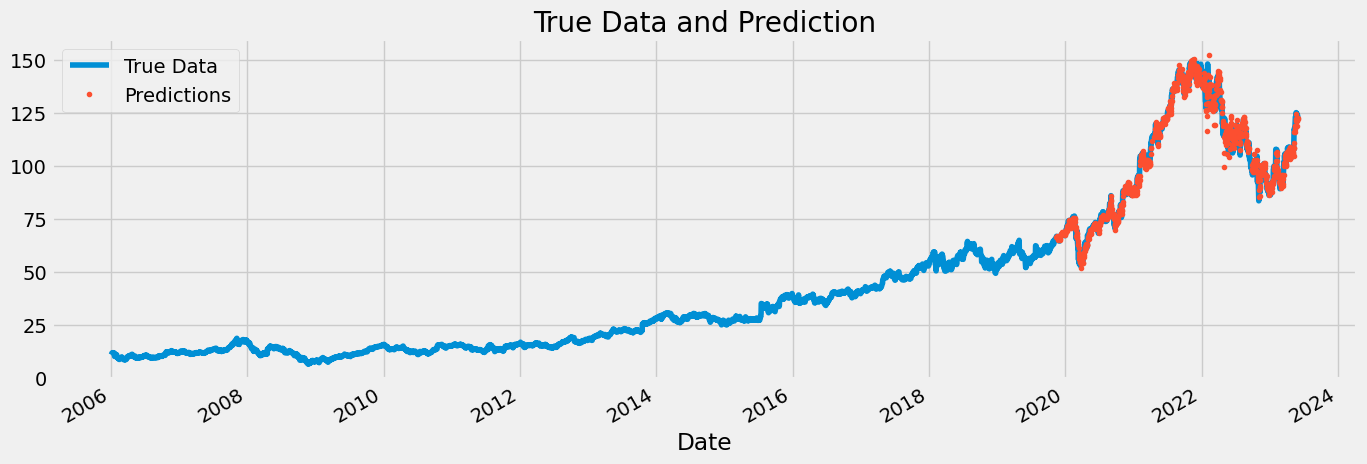

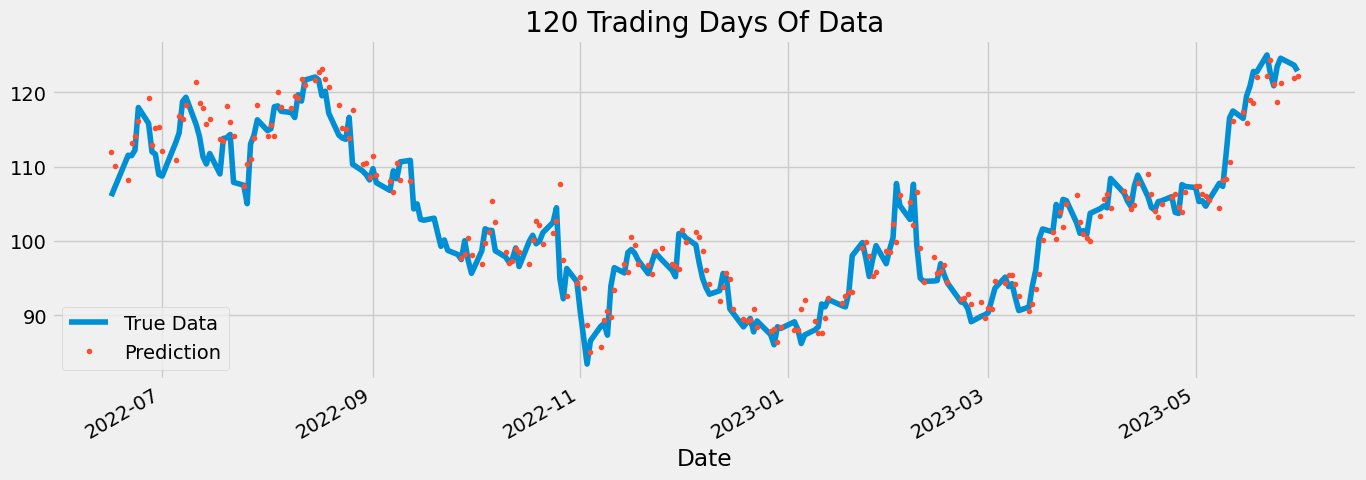

In [9]:
# Visualize results
print(f'RMSE across folds {np.mean(scores_gru):0.4f}')
print(f'Fold RMSE: {scores_gru}')
plot_predictions(df, preds_gru) 